# Task 1: QA/QC – Make Dataset Analysis-Ready

**Objective:**  
To prepare the dataset for analysis by applying a reproducible QA/QC pipeline.  
This includes:
- Aligning timestamps (flagging DST, duplicates, clock drift),
- Flagging out-of-range, missing, and flat-lined readings,
- Resampling to a strict hourly grid,
- Producing an analysis-ready dataset with QC transparency.


### Import libraries & load dataset.

Explicitly enforced UTC timezone (+00:00), even though timestamps already include UTC — ensures reproducibility.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# File paths
MEAS_PATH = "/Users/fathhi/Desktop/Interview Tasks/Air_Quality_Analysis/data/earthsense_measurements.csv"

# Load measurements
df_measurements = pd.read_csv(MEAS_PATH, parse_dates=["timestamp_recorded_utc"])

# Ensure UTC (dataset already shows +00:00, but enforce anyway)
df_measurements["timestamp_recorded_utc"] = (
    df_measurements["timestamp_recorded_utc"].dt.tz_convert("UTC")
    if df_measurements["timestamp_recorded_utc"].dt.tz is not None
    else df_measurements["timestamp_recorded_utc"].dt.tz_localize("UTC")
)





### Dataset Overview

- 22,760 rows and 9 columns.

- Each row = one sensor reading at a given hour.

- Columns include pollutants (NO₂, PM₂.₅), environmental data (Temp, RH), metadata (firmware, status).

- Missing data: 361 rows missing pollutant values (NO₂ and PM₂.₅).

- Environmental variables (Temp, RH) and metadata (status, firmware) are fully present.

In [3]:

# Task 1: QA/QC - Step 2

# Shape of dataset
n_rows, n_cols = df_measurements.shape
print(f"Dataset contains {n_rows:,} rows and {n_cols} columns.\n")

# Column information
print("Column info:")
print(df_measurements.dtypes)
print("\n")

# Check for missing values per column
print("Missing values per column:")
print(df_measurements.isna().sum())

# Quick descriptive stats for numeric columns
print("\nBasic statistics (numeric columns):")
display(df_measurements.describe().T)


Dataset contains 22,760 rows and 9 columns.

Column info:
sensor_id                              object
timestamp_recorded_utc    datetime64[ns, UTC]
no2_ppb                               float64
pm25_ugm3                             float64
temp_c                                float64
rh_pct                                float64
firmware                               object
status                                 object
no2_ugm3                              float64
dtype: object


Missing values per column:
sensor_id                   0
timestamp_recorded_utc      0
no2_ppb                   361
pm25_ugm3                 361
temp_c                      0
rh_pct                      0
firmware                    0
status                      0
no2_ugm3                  361
dtype: int64

Basic statistics (numeric columns):


,count,mean,std,min,25%,50%,75%,max
no2_ppb,22399.0,28.539841,7.949201,4.60,22.8700,28.03,33.6600,84.53
pm25_ugm3,22399.0,10.095268,4.094157,-5.84,7.4700,9.53,11.7500,30.40
temp_c,22760.0,17.968587,4.450186,6.68,13.9400,17.99,22.0700,27.89
rh_pct,22760.0,59.560071,16.574302,17.90,46.1375,59.28,73.1225,107.71
no2_ugm3,22399.0,54.925444,15.151843,8.93,44.1700,54.01,64.6700,159.25


In [4]:
# Quick preview
df_measurements.head(10)

,sensor_id,timestamp_recorded_utc,no2_ppb,pm25_ugm3,temp_c,rh_pct,firmware,status,no2_ugm3
0,ZEPHYR_001,2025-06-15 00:00:00+00:00,25.20,6.67,12.42,77.34,1.4.2,OK,49.47
1,ZEPHYR_001,2025-06-15 01:00:00+00:00,22.16,8.62,9.66,81.89,1.4.2,OK,43.93
2,ZEPHYR_001,2025-06-15 02:00:00+00:00,20.43,11.01,10.89,85.90,1.4.2,OK,40.33
3,ZEPHYR_001,2025-06-15 03:00:00+00:00,17.73,2.65,12.80,98.05,1.4.2,OK,34.76
4,ZEPHYR_001,2025-06-15 04:00:00+00:00,19.32,14.30,12.89,91.62,1.4.2,OK,37.87
5,ZEPHYR_001,2025-06-15 05:00:00+00:00,25.02,10.65,11.89,67.69,1.4.2,OK,49.21
6,ZEPHYR_001,2025-06-15 06:00:00+00:00,24.36,7.34,15.31,86.84,1.4.2,OK,47.35
7,ZEPHYR_001,2025-06-15 07:00:00+00:00,24.28,12.42,16.91,59.22,1.4.2,OK,46.93
8,ZEPHYR_001,2025-06-15 08:00:00+00:00,20.64,7.46,17.79,68.52,1.4.2,OK,39.77
9,ZEPHYR_001,2025-06-15 09:00:00+00:00,31.57,9.95,19.33,59.12,1.4.2,OK,60.52


In [5]:
# Quick preview
df_measurements.tail(10)

,sensor_id,timestamp_recorded_utc,no2_ppb,pm25_ugm3,temp_c,rh_pct,firmware,status,no2_ugm3
22750,ZEPHYR_015,2025-07-06 19:00:00+00:00,17.76,7.21,21.86,53.49,1.4.2,OK,33.75
22751,ZEPHYR_015,2025-07-30 14:00:00+00:00,23.50,8.03,24.88,35.33,1.4.2,OK,44.21
22752,ZEPHYR_015,2025-07-14 17:00:00+00:00,15.68,9.31,23.26,63.24,1.4.2,OK,29.66
22753,ZEPHYR_015,2025-07-16 21:00:00+00:00,16.93,6.49,16.23,59.78,1.4.2,OK,32.80
22754,ZEPHYR_015,2025-07-18 16:00:00+00:00,24.49,6.22,25.28,31.22,1.4.2,OK,46.01
22755,ZEPHYR_015,2025-06-26 14:00:00+00:00,25.25,11.60,22.51,24.41,1.4.2,OK,47.88
22756,ZEPHYR_015,2025-06-29 16:00:00+00:00,20.18,9.68,24.34,45.60,1.4.2,OK,38.03
22757,ZEPHYR_015,2025-06-17 10:00:00+00:00,32.92,5.68,22.14,56.59,1.4.2,OK,62.50
22758,ZEPHYR_015,2025-07-27 12:00:00+00:00,23.24,9.71,23.33,40.83,1.4.2,OK,43.95
22759,ZEPHYR_015,2025-06-29 11:00:00+00:00,27.44,6.22,20.52,55.88,1.4.2,OK,52.39


In [6]:

df_measurements["sensor_id"].unique()


array(['ZEPHYR_001', 'ZEPHYR_002', 'ZEPHYR_003', 'ZEPHYR_004',
       'ZEPHYR_005', 'ZEPHYR_006', 'ZEPHYR_007', 'ZEPHYR_008',
       'ZEPHYR_009', 'ZEPHYR_010', 'ZEPHYR_011', 'ZEPHYR_012',
       'ZEPHYR_013', 'ZEPHYR_014', 'ZEPHYR_015', 'ZEPHYR_016',
       'ZEPHYR_017', 'ZEPHYR_018', 'ZEPHYR_019', 'ZEPHYR_020'],
      dtype=object)

sensor_id
ZEPHYR_001    1128
ZEPHYR_002    1128
ZEPHYR_003    1128
ZEPHYR_004    1128
ZEPHYR_005    1128
ZEPHYR_006    1128
ZEPHYR_007    1128
ZEPHYR_008    1128
ZEPHYR_009    1128
ZEPHYR_010    1128
ZEPHYR_011    1128
ZEPHYR_012    1128
ZEPHYR_013    1128
ZEPHYR_014    1128
ZEPHYR_015    1328
ZEPHYR_016    1128
ZEPHYR_017    1128
ZEPHYR_018    1128
ZEPHYR_019    1128
ZEPHYR_020    1128
Name: count, dtype: int64

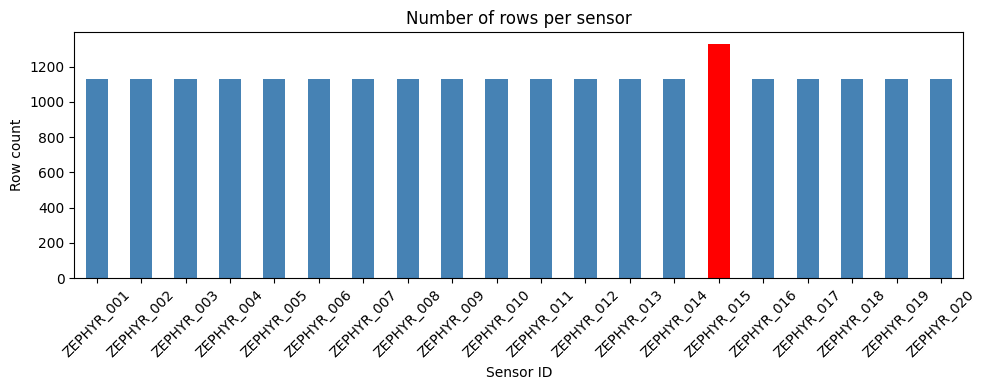

In [7]:
# How many rows per sensor?
counts = df_measurements["sensor_id"].value_counts().sort_index()

# Display counts table
display(counts)

# Plot counts
plt.figure(figsize=(10,4))
counts.plot(kind="bar", color=["red" if s=="ZEPHYR_015" else "steelblue" for s in counts.index])
plt.title("Number of rows per sensor")
plt.xlabel("Sensor ID")
plt.ylabel("Row count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Duplicate Detection

- No full-row duplicates were found.

- A total of 201 duplicate timestamps were detected, all in sensor ZEPHYR_015.

- This anomaly is consistent with the documented clock-shift bug (June 20 → July 1) in the changelog.

- Duplicates were flagged (flag_timestamp_duplicate=1), not removed, to preserve transparency.

In [8]:
df_dups = df_measurements.copy()

# Flag duplicate timestamps per sensor
df_dups["flag_timestamp_duplicate"] = df_dups.duplicated(
    subset=["sensor_id","timestamp_recorded_utc"]
).astype(int)

# Count total
dup_total = df_dups["flag_timestamp_duplicate"].sum()
print("Total timestamp duplicates:", dup_total)

# Count by sensor
dup_counts = (
    df_dups.loc[df_dups["flag_timestamp_duplicate"]==1]
    .groupby("sensor_id")["timestamp_recorded_utc"]
    .count()
    .sort_index()
)

display(dup_counts)


Total timestamp duplicates: 201


sensor_id
ZEPHYR_015    201
Name: timestamp_recorded_utc, dtype: int64

In [9]:
df_dups.head(5)

,sensor_id,timestamp_recorded_utc,no2_ppb,pm25_ugm3,temp_c,rh_pct,firmware,status,no2_ugm3,flag_timestamp_duplicate
0,ZEPHYR_001,2025-06-15 00:00:00+00:00,25.20,6.67,12.42,77.34,1.4.2,OK,49.47,0
1,ZEPHYR_001,2025-06-15 01:00:00+00:00,22.16,8.62,9.66,81.89,1.4.2,OK,43.93,0
2,ZEPHYR_001,2025-06-15 02:00:00+00:00,20.43,11.01,10.89,85.90,1.4.2,OK,40.33,0
3,ZEPHYR_001,2025-06-15 03:00:00+00:00,17.73,2.65,12.80,98.05,1.4.2,OK,34.76,0
4,ZEPHYR_001,2025-06-15 04:00:00+00:00,19.32,14.30,12.89,91.62,1.4.2,OK,37.87,0


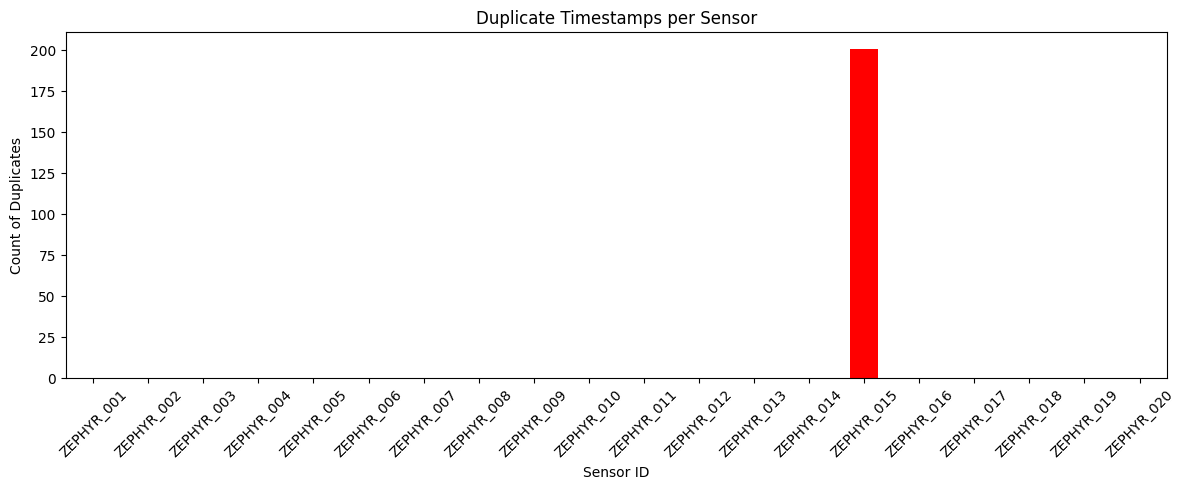

sensor_id
ZEPHYR_001      0
ZEPHYR_002      0
ZEPHYR_003      0
ZEPHYR_004      0
ZEPHYR_005      0
ZEPHYR_006      0
ZEPHYR_007      0
ZEPHYR_008      0
ZEPHYR_009      0
ZEPHYR_010      0
ZEPHYR_011      0
ZEPHYR_012      0
ZEPHYR_013      0
ZEPHYR_014      0
ZEPHYR_015    201
ZEPHYR_016      0
ZEPHYR_017      0
ZEPHYR_018      0
ZEPHYR_019      0
ZEPHYR_020      0
Name: flag_timestamp_duplicate, dtype: int64

In [10]:
dup_counts_all = (
    df_dups.groupby("sensor_id")["flag_timestamp_duplicate"]
    .sum()
    .reindex(sorted(df_dups["sensor_id"].unique()))  # sort sensors 001–020
)

# Plot
plt.figure(figsize=(12,5))
colors = ["red" if s=="ZEPHYR_015" else "grey" for s in dup_counts_all.index]

dup_counts_all.plot(kind="bar", color=colors)
plt.title("Duplicate Timestamps per Sensor")
plt.xlabel("Sensor ID")
plt.ylabel("Count of Duplicates")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

dup_counts_all


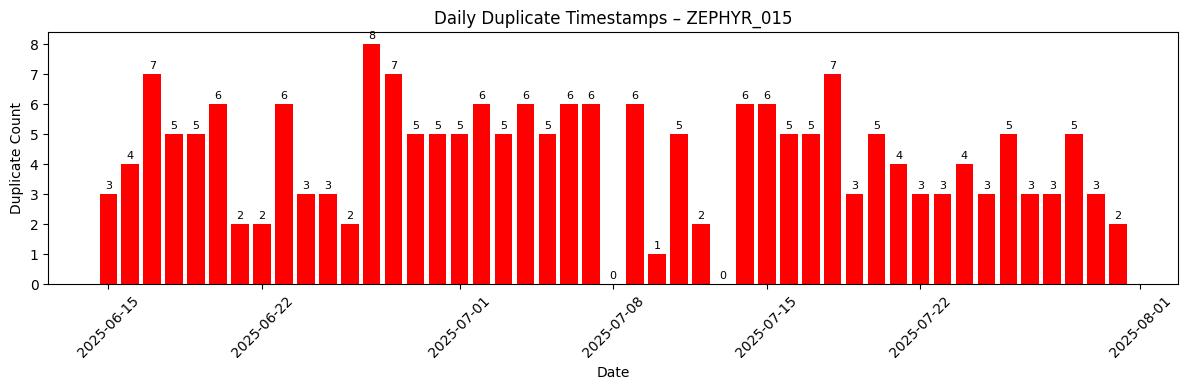

In [11]:

sensor = "ZEPHYR_015"
df_sensor_dups = df_dups[df_dups["sensor_id"] == sensor]


dup_counts_by_date = (
    df_sensor_dups.groupby(df_sensor_dups["timestamp_recorded_utc"].dt.date)["flag_timestamp_duplicate"]
    .sum()
)


plt.figure(figsize=(12,4))
bars = plt.bar(dup_counts_by_date.index, dup_counts_by_date.values, color="red")


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1, str(int(height)),
             ha="center", va="bottom", fontsize=8)

plt.title(f"Daily Duplicate Timestamps – {sensor}")
plt.xlabel("Date")
plt.ylabel("Duplicate Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


ZEPHYR_015 shows daily duplicate timestamps 201 flagged rows across the study period), not limited to the 20 June–1 July clock-shift bug window. This suggests a sensor-specific logging or backend ingestion issue, rather than a one-off clock shift. Further inspection of raw timestamps and duplicate values is needed to confirm whether these were exact repeats (pipeline duplication) or near-repeats (sensor double-logging).

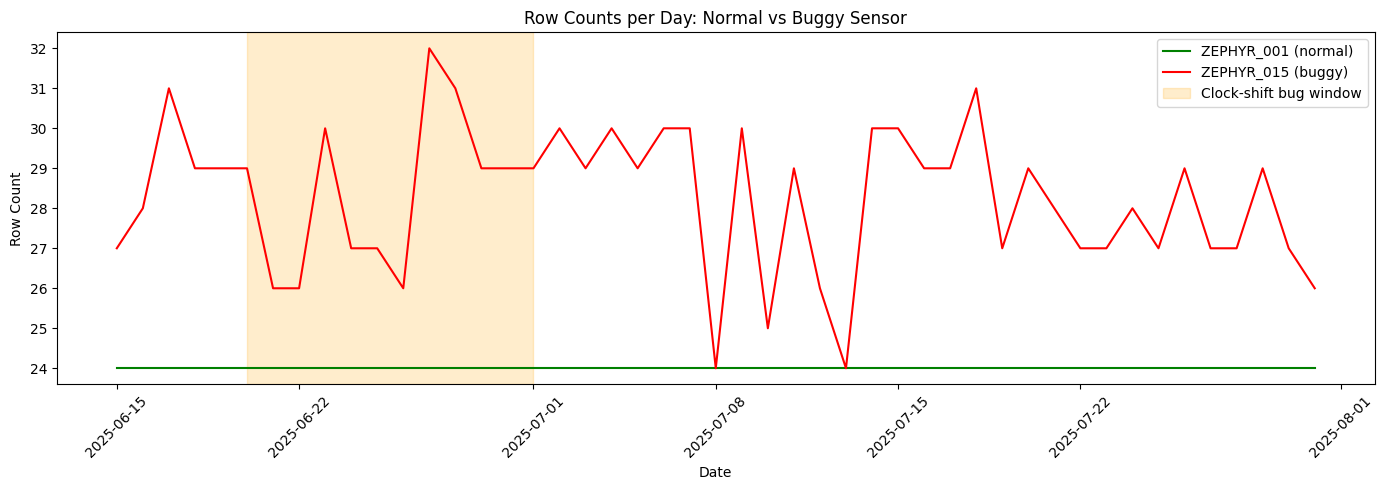

In [12]:

# Pick two sensors: one normal (ZEPHYR_001) and the buggy one (ZEPHYR_015)
sensor_ok = "ZEPHYR_001"
sensor_bug = "ZEPHYR_015"

df_ok = df_measurements[df_measurements["sensor_id"] == sensor_ok]
df_bug = df_measurements[df_measurements["sensor_id"] == sensor_bug]

# Plot number of rows per day for both sensors
rows_per_day_ok = df_ok.groupby(df_ok["timestamp_recorded_utc"].dt.date).size()
rows_per_day_bug = df_bug.groupby(df_bug["timestamp_recorded_utc"].dt.date).size()

plt.figure(figsize=(14,5))
plt.plot(rows_per_day_ok.index, rows_per_day_ok.values, label=f"{sensor_ok} (normal)", color="green")
plt.plot(rows_per_day_bug.index, rows_per_day_bug.values, label=f"{sensor_bug} (buggy)", color="red")

# Highlight bug period (2025-06-20 → 2025-07-01)
plt.axvspan(pd.to_datetime("2025-06-20"), pd.to_datetime("2025-07-01"),
            color="orange", alpha=0.2, label="Clock-shift bug window")

plt.title("Row Counts per Day: Normal vs Buggy Sensor")
plt.xlabel("Date")
plt.ylabel("Row Count")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The changelog documents the clock-shift bug for ZEPHYR_015 between 2025-06-20 and 2025-07-01, during which our QC flagged 201 duplicate timestamps.
However, our row-count analysis shows anomalies continuing after July 1, with ZEPHYR_015 still producing irregular daily counts (25–32 rows instead of 24).
This suggests the sensor did not fully recover immediately on July 1, and some timestamp instability persisted beyond the documented window.

### Out of Range & Negative Values

In [13]:
# Define valid ranges for each variable (based on WHO/EU/UK guidelines)
# ---------------------------------------------------------

valid_ranges = {
    "no2_ppb":   (0, 100),    # NO₂ (ppb), EU guideline ≈106 ppb
    "no2_ugm3":  (0, 200),    # NO₂ (µg/m³), EU hourly limit = 200 µg/m³
    "pm25_ugm3": (0, 35),     # PM₂.₅ (µg/m³), WHO 24h guideline
    "rh_pct":    (0, 100),    # Relative humidity (%), physical limit
    "temp_c":    (-10, 35),   # Temperature (°C), UK June–July realistic range
}


In [14]:
df_or = df_measurements.copy()

for col, (low, high) in valid_ranges.items():
    df_or[f"flag_out_of_range__{col}"] = (
        (df_or[col] < low) | (df_or[col] > high)
    ).astype(int)

# Quick summary
out_of_range_counts = {
    col: df_or[f"flag_out_of_range__{col}"].sum() for col in valid_ranges
}
print("Out-of-range counts:", out_of_range_counts)


Out-of-range counts: {'no2_ppb': np.int64(0), 'no2_ugm3': np.int64(0), 'pm25_ugm3': np.int64(14), 'rh_pct': np.int64(37), 'temp_c': np.int64(0)}


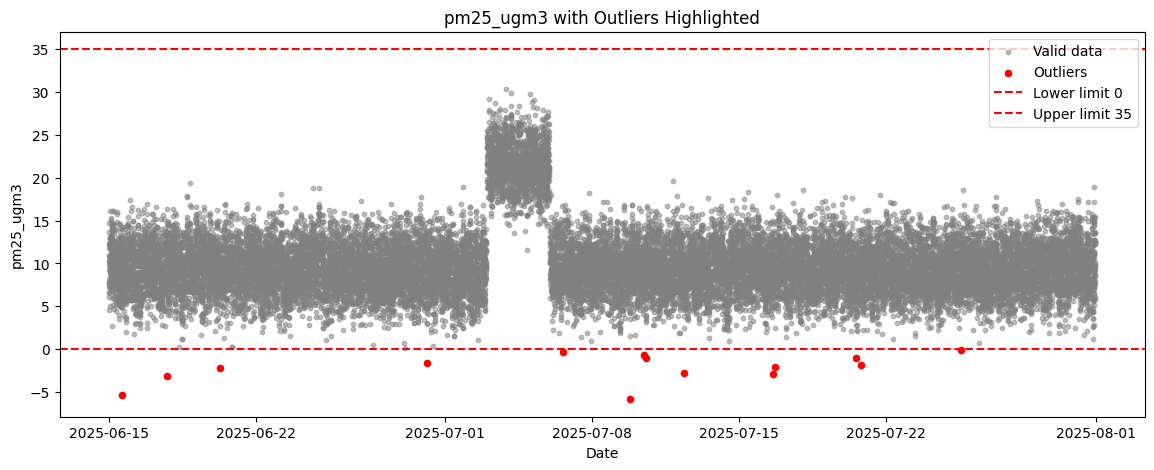

In [15]:
col = "pm25_ugm3"
low, high = valid_ranges[col]

plt.figure(figsize=(14,5))
plt.scatter(df_or["timestamp_recorded_utc"], df_or[col], s=10, alpha=0.5, color="grey", label="Valid data")

# Highlight outliers in red
outliers = df_or[(df_or[col] < low) | (df_or[col] > high)]
plt.scatter(outliers["timestamp_recorded_utc"], outliers[col], s=20, color="red", label="Outliers")

# Reference lines
plt.axhline(low, color="red", linestyle="--", label=f"Lower limit {low}")
plt.axhline(high, color="red", linestyle="--", label=f"Upper limit {high}")

plt.title(f"{col} with Outliers Highlighted")
plt.xlabel("Date")
plt.ylabel(col)
plt.legend()
plt.show()


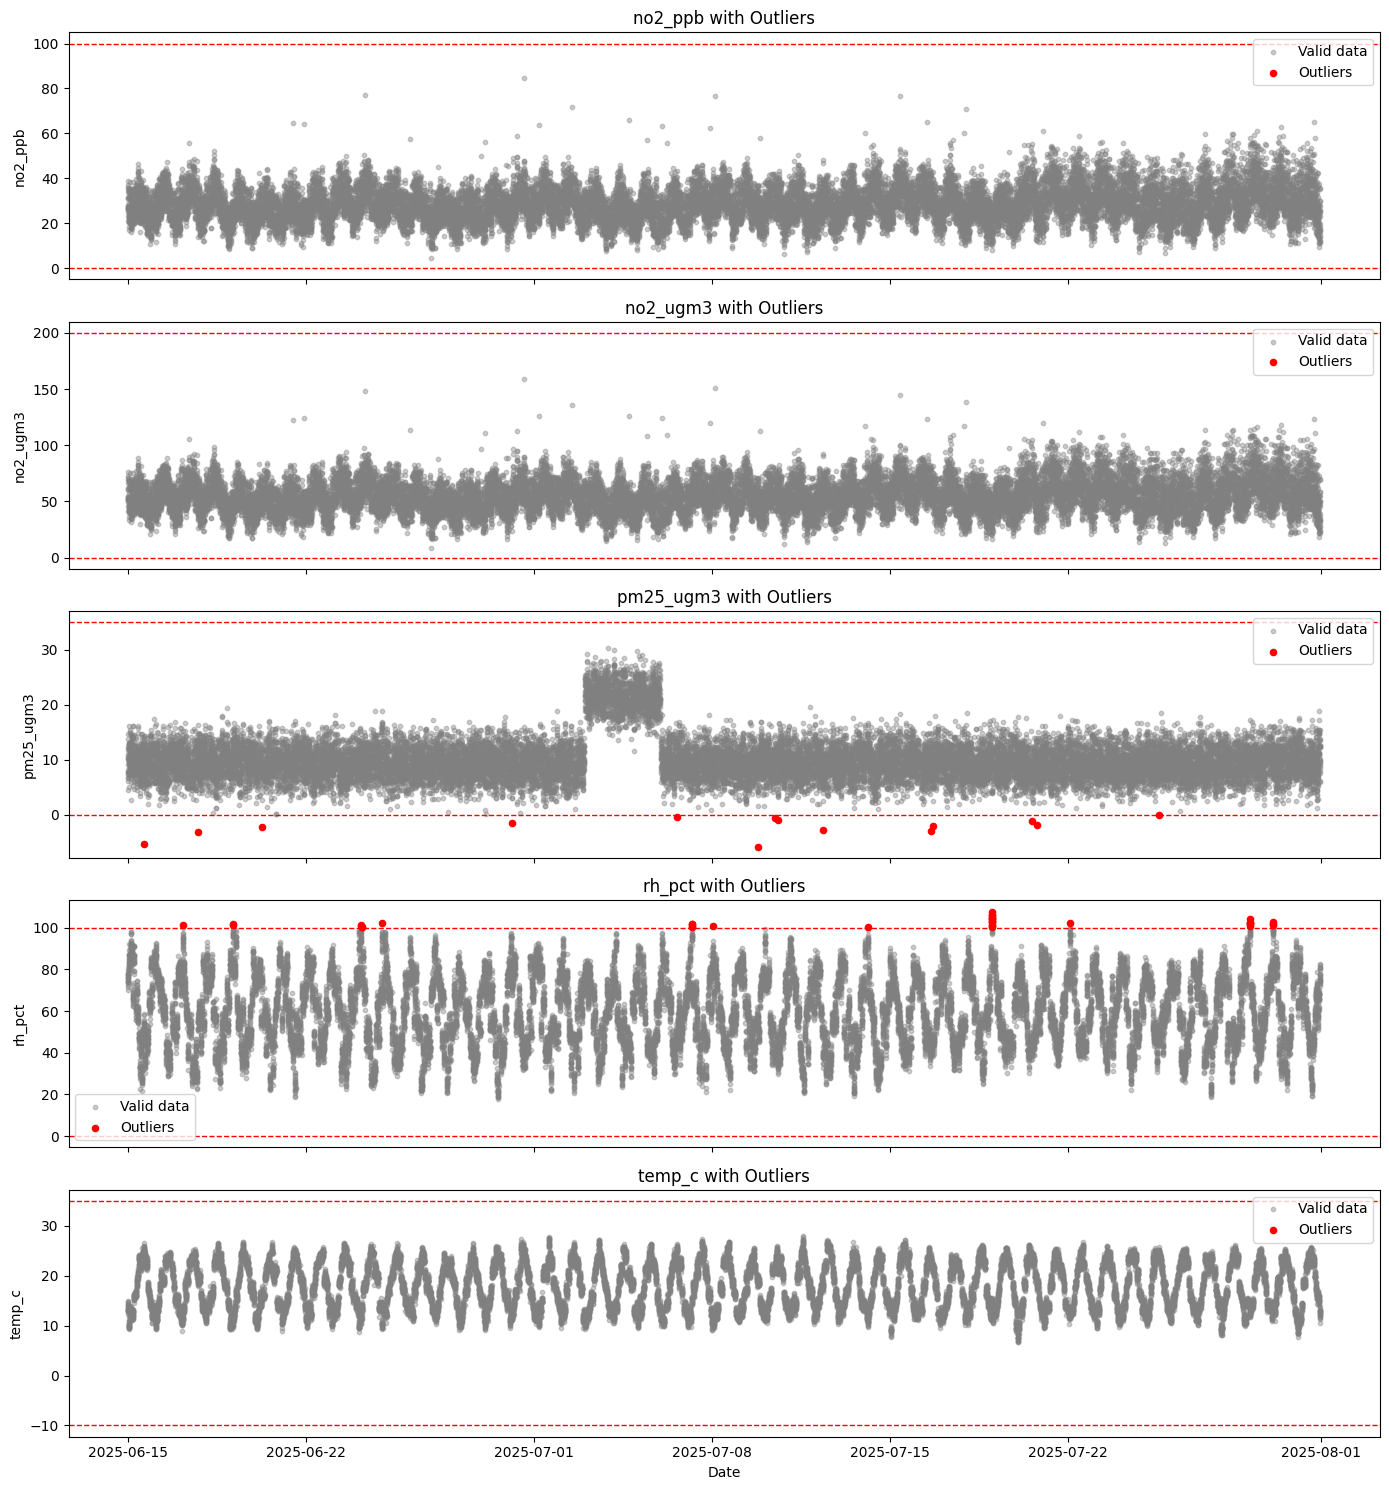

In [16]:
variables = ["no2_ppb", "no2_ugm3", "pm25_ugm3", "rh_pct", "temp_c"]

fig, axes = plt.subplots(len(variables), 1, figsize=(14, 3*len(variables)), sharex=True)

for i, col in enumerate(variables):
    low, high = valid_ranges[col]
    
    # Scatter all points
    axes[i].scatter(df_or["timestamp_recorded_utc"], df_or[col], 
                    s=10, alpha=0.4, color="grey", label="Valid data")
    
    # Highlight outliers
    outliers = df_or[(df_or[col] < low) | (df_or[col] > high)]
    axes[i].scatter(outliers["timestamp_recorded_utc"], outliers[col],
                    s=20, color="red", label="Outliers")
    
    # Reference lines
    axes[i].axhline(low, color="red", linestyle="--", linewidth=1)
    axes[i].axhline(high, color="red", linestyle="--", linewidth=1)
    
    axes[i].set_title(f"{col} with Outliers")
    axes[i].set_ylabel(col)
    axes[i].legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()






Out-of-range and negative values were flagged for all key variables:

NO₂ (ppb and µg/m³), PM₂.₅, RH, and Temperature.

Each variable has its own flag column (e.g., flag_out_of_range__pm25_ugm3).

A combined flag (flag_outlier_any) marks any row containing one or more outliers.

This approach preserves all data while making quality issues explicit.

In [17]:
# Copy dataframe to preserve original
df_flags = df_measurements.copy()

# Apply out-of-range flags for each variable
for col, (low, high) in valid_ranges.items():
    df_flags[f"flag_out_of_range__{col}"] = (
        (df_flags[col] < low) | (df_flags[col] > high)
    ).astype(int)

# Create combined flag (any variable out of range)
df_flags["flag_outlier_any"] = df_flags[
    [c for c in df_flags.columns if c.startswith("flag_out_of_range__")]
].max(axis=1)

# Quick check: how many rows flagged?
print("Rows flagged as outliers:", df_flags["flag_outlier_any"].sum())


Rows flagged as outliers: 51


In [18]:
# Collect outlier counts
outlier_summary = {
    "NO₂ (ppb)":   int(df_flags["flag_out_of_range__no2_ppb"].sum()),
    "NO₂ (µg/m³)": int(df_flags["flag_out_of_range__no2_ugm3"].sum()),
    "PM₂.₅ (µg/m³)": int(df_flags["flag_out_of_range__pm25_ugm3"].sum()),
    "Relative Humidity (%)": int(df_flags["flag_out_of_range__rh_pct"].sum()),
    "Temperature (°C)": int(df_flags["flag_out_of_range__temp_c"].sum()),
}

# Convert to DataFrame for display
import pandas as pd
outlier_table = pd.DataFrame.from_dict(outlier_summary, orient="index", columns=["Outlier Count"])
outlier_table


,Outlier Count
NO₂ (ppb),0
NO₂ (µg/m³),0
PM₂.₅ (µg/m³),14
Relative Humidity (%),37
Temperature (°C),0


In [19]:
df_flags.head(5)

,sensor_id,timestamp_recorded_utc,no2_ppb,pm25_ugm3,temp_c,rh_pct,firmware,status,no2_ugm3,flag_out_of_range__no2_ppb,flag_out_of_range__no2_ugm3,flag_out_of_range__pm25_ugm3,flag_out_of_range__rh_pct,flag_out_of_range__temp_c,flag_outlier_any
0,ZEPHYR_001,2025-06-15 00:00:00+00:00,25.20,6.67,12.42,77.34,1.4.2,OK,49.47,0,0,0,0,0,0
1,ZEPHYR_001,2025-06-15 01:00:00+00:00,22.16,8.62,9.66,81.89,1.4.2,OK,43.93,0,0,0,0,0,0
2,ZEPHYR_001,2025-06-15 02:00:00+00:00,20.43,11.01,10.89,85.90,1.4.2,OK,40.33,0,0,0,0,0,0
3,ZEPHYR_001,2025-06-15 03:00:00+00:00,17.73,2.65,12.80,98.05,1.4.2,OK,34.76,0,0,0,0,0,0
4,ZEPHYR_001,2025-06-15 04:00:00+00:00,19.32,14.30,12.89,91.62,1.4.2,OK,37.87,0,0,0,0,0,0


### Missing Values

In [20]:
# Flag missing values
for col in ["no2_ppb", "no2_ugm3", "pm25_ugm3", "temp_c", "rh_pct"]:
    df_flags[f"flag_missing__{col}"] = df_flags[col].isna().astype(int)

# Combined missing flag
df_flags["flag_missing_any"] = df_flags[
    [c for c in df_flags.columns if c.startswith("flag_missing__")]
].max(axis=1)

# Quick summary
missing_counts = {
    col: df_flags[f"flag_missing__{col}"].sum() for col in ["no2_ppb","no2_ugm3","pm25_ugm3","temp_c","rh_pct"]
}
print("Missing counts per variable:", missing_counts)
print("Rows with any missing value:", df_flags["flag_missing_any"].sum())


Missing counts per variable: {'no2_ppb': np.int64(361), 'no2_ugm3': np.int64(361), 'pm25_ugm3': np.int64(361), 'temp_c': np.int64(0), 'rh_pct': np.int64(0)}
Rows with any missing value: 361


In [21]:
df_flags.head(5)

,sensor_id,timestamp_recorded_utc,no2_ppb,pm25_ugm3,temp_c,rh_pct,firmware,status,no2_ugm3,flag_out_of_range__no2_ppb,...,flag_out_of_range__pm25_ugm3,flag_out_of_range__rh_pct,flag_out_of_range__temp_c,flag_outlier_any,flag_missing__no2_ppb,flag_missing__no2_ugm3,flag_missing__pm25_ugm3,flag_missing__temp_c,flag_missing__rh_pct,flag_missing_any
0,ZEPHYR_001,2025-06-15 00:00:00+00:00,25.20,6.67,12.42,77.34,1.4.2,OK,49.47,0,...,0,0,0,0,0,0,0,0,0,0
1,ZEPHYR_001,2025-06-15 01:00:00+00:00,22.16,8.62,9.66,81.89,1.4.2,OK,43.93,0,...,0,0,0,0,0,0,0,0,0,0
2,ZEPHYR_001,2025-06-15 02:00:00+00:00,20.43,11.01,10.89,85.90,1.4.2,OK,40.33,0,...,0,0,0,0,0,0,0,0,0,0
3,ZEPHYR_001,2025-06-15 03:00:00+00:00,17.73,2.65,12.80,98.05,1.4.2,OK,34.76,0,...,0,0,0,0,0,0,0,0,0,0
4,ZEPHYR_001,2025-06-15 04:00:00+00:00,19.32,14.30,12.89,91.62,1.4.2,OK,37.87,0,...,0,0,0,0,0,0,0,0,0,0


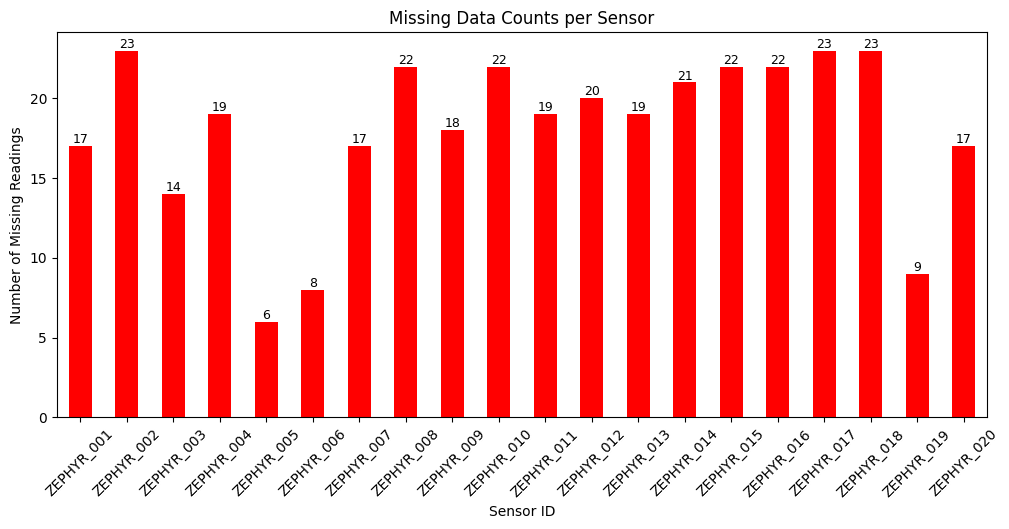

Missing counts per sensor:
sensor_id
ZEPHYR_018    23
ZEPHYR_017    23
ZEPHYR_002    23
ZEPHYR_016    22
ZEPHYR_015    22
ZEPHYR_008    22
ZEPHYR_010    22
ZEPHYR_014    21
ZEPHYR_012    20
ZEPHYR_011    19
ZEPHYR_004    19
ZEPHYR_013    19
ZEPHYR_009    18
ZEPHYR_001    17
ZEPHYR_007    17
ZEPHYR_020    17
ZEPHYR_003    14
ZEPHYR_019     9
ZEPHYR_006     8
ZEPHYR_005     6
Name: flag_missing_any, dtype: int64


In [22]:
# Count missing rows per sensor (any variable missing)
missing_counts_sensor = (
    df_flags.groupby("sensor_id")["flag_missing_any"].sum()
)

plt.figure(figsize=(12,5))
ax = missing_counts_sensor.plot(kind="bar", color="red")

plt.title("Missing Data Counts per Sensor")
plt.ylabel("Number of Missing Readings")
plt.xlabel("Sensor ID")
plt.xticks(rotation=45)

# Add counts above each bar
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=9, color='black')

plt.show()

print("Missing counts per sensor:")
print(missing_counts_sensor.sort_values(ascending=False))


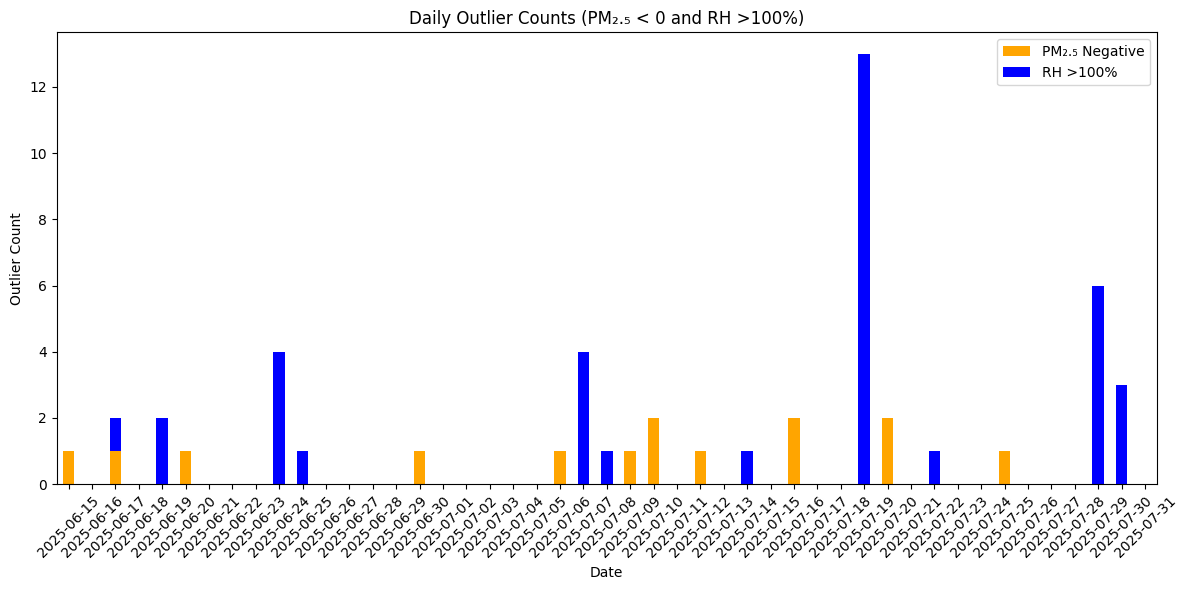

In [23]:
# Build daily counts for PM2.5 and RH artefacts only
daily_outliers = (
    df_flags.assign(date = df_flags["timestamp_recorded_utc"].dt.date)
    .groupby("date")[["flag_out_of_range__pm25_ugm3", "flag_out_of_range__rh_pct"]]
    .sum()
)

# Plot
daily_outliers.plot(kind="bar", stacked=True, figsize=(12,6), color=["orange","blue"])
plt.title("Daily Outlier Counts (PM₂.₅ < 0 and RH >100%)")
plt.xlabel("Date")
plt.ylabel("Outlier Count")
plt.xticks(rotation=45)
plt.legend(["PM₂.₅ Negative", "RH >100%"])
plt.tight_layout()
plt.show()


In [24]:
# Add a date column for grouping
df_flags = df_flags.copy()
df_flags["date"] = df_flags["timestamp_recorded_utc"].dt.date

# PM2.5 < 0
pm25_neg_daily = (
    df_flags.loc[df_flags["flag_out_of_range__pm25_ugm3"] == 1]
    .groupby("date").size()
    .rename("PM2.5 Negative Count")
)

# RH > 100%
rh_high_daily = (
    df_flags.loc[df_flags["flag_out_of_range__rh_pct"] == 1]
    .groupby("date").size()
    .rename("RH >100% Count")
)

# Combine into one table
outlier_dates_table = pd.concat([pm25_neg_daily, rh_high_daily], axis=1).fillna(0).astype(int)

# Add totals row
outlier_dates_table.loc["TOTAL"] = outlier_dates_table.sum()

outlier_dates_table


,PM2.5 Negative Count,RH >100% Count
date,,
2025-06-15,1,0
2025-06-17,1,1
2025-06-20,1,0
2025-06-30,1,0
2025-07-06,1,0
2025-07-09,1,0
2025-07-10,2,0
2025-07-12,1,0
2025-07-16,2,0


In [25]:
df_flags.columns

Index(['sensor_id', 'timestamp_recorded_utc', 'no2_ppb', 'pm25_ugm3', 'temp_c',
       'rh_pct', 'firmware', 'status', 'no2_ugm3',
       'flag_out_of_range__no2_ppb', 'flag_out_of_range__no2_ugm3',
       'flag_out_of_range__pm25_ugm3', 'flag_out_of_range__rh_pct',
       'flag_out_of_range__temp_c', 'flag_outlier_any',
       'flag_missing__no2_ppb', 'flag_missing__no2_ugm3',
       'flag_missing__pm25_ugm3', 'flag_missing__temp_c',
       'flag_missing__rh_pct', 'flag_missing_any', 'date'],
      dtype='object')

### Flat line check

In [26]:
window = 5  # number of consecutive readings to check

df_flags = df_flags.copy()  # make sure we're working with the flagged dataset

for col in ["no2_ppb", "no2_ugm3", "pm25_ugm3", "temp_c", "rh_pct"]:
    df_flags[f"flag_flatline__{col}"] = (
        df_flags.groupby("sensor_id")[col]
        .transform(lambda x: x.rolling(window=window, min_periods=window)
                              .apply(lambda w: int(len(set(w)) == 1), raw=False))
        .fillna(0)
        .astype(int)
    )

# Combined flag (any variable flatlined)
df_flags["flag_flatline_any"] = df_flags[
    [c for c in df_flags.columns if c.startswith("flag_flatline__")]
].max(axis=1)


In [27]:
flatline_counts = {
    col: df_flags[f"flag_flatline__{col}"].sum() 
    for col in ["no2_ppb", "no2_ugm3", "pm25_ugm3", "temp_c", "rh_pct"]
}
print("Flatline counts per variable:", flatline_counts)
print("Rows flagged as flatline (any variable):", df_flags["flag_flatline_any"].sum())


Flatline counts per variable: {'no2_ppb': np.int64(0), 'no2_ugm3': np.int64(0), 'pm25_ugm3': np.int64(0), 'temp_c': np.int64(0), 'rh_pct': np.int64(0)}
Rows flagged as flatline (any variable): 0


In [28]:
df_flags.columns

Index(['sensor_id', 'timestamp_recorded_utc', 'no2_ppb', 'pm25_ugm3', 'temp_c',
       'rh_pct', 'firmware', 'status', 'no2_ugm3',
       'flag_out_of_range__no2_ppb', 'flag_out_of_range__no2_ugm3',
       'flag_out_of_range__pm25_ugm3', 'flag_out_of_range__rh_pct',
       'flag_out_of_range__temp_c', 'flag_outlier_any',
       'flag_missing__no2_ppb', 'flag_missing__no2_ugm3',
       'flag_missing__pm25_ugm3', 'flag_missing__temp_c',
       'flag_missing__rh_pct', 'flag_missing_any', 'date',
       'flag_flatline__no2_ppb', 'flag_flatline__no2_ugm3',
       'flag_flatline__pm25_ugm3', 'flag_flatline__temp_c',
       'flag_flatline__rh_pct', 'flag_flatline_any'],
      dtype='object')

Flatline Detection
We applied a rolling-window check (5-hour window) to flag potential flat-lined values (i.e., repeated identical readings).
Flat-lining would indicate a possible sensor freeze or malfunction.

Result: No flat-line periods were detected in NO₂, PM₂.₅, RH, or temperature across any sensors.
This suggests that all sensors maintained natural variability in their signals, with no evidence of data “stuck” at a constant value.

In [29]:
# Drop flatline-related columns
flatline_cols = [c for c in df_flags.columns if "flatline" in c]
df_flags = df_flags.drop(columns=flatline_cols)

print("Removed flatline columns. Current columns are:")
print(df_flags.columns)


Removed flatline columns. Current columns are:
Index(['sensor_id', 'timestamp_recorded_utc', 'no2_ppb', 'pm25_ugm3', 'temp_c',
       'rh_pct', 'firmware', 'status', 'no2_ugm3',
       'flag_out_of_range__no2_ppb', 'flag_out_of_range__no2_ugm3',
       'flag_out_of_range__pm25_ugm3', 'flag_out_of_range__rh_pct',
       'flag_out_of_range__temp_c', 'flag_outlier_any',
       'flag_missing__no2_ppb', 'flag_missing__no2_ugm3',
       'flag_missing__pm25_ugm3', 'flag_missing__temp_c',
       'flag_missing__rh_pct', 'flag_missing_any', 'date'],
      dtype='object')


### Resampling Data

In [30]:
# Step 1. Set timestamp as index
df_resampled = df_flags.set_index("timestamp_recorded_utc")

# Step 2. Resample numeric columns (mean if duplicates exist)
numeric_cols = ["no2_ppb", "no2_ugm3", "pm25_ugm3", "temp_c", "rh_pct"]
df_hourly_data = (
    df_resampled.groupby("sensor_id")[numeric_cols]
    .resample("1H")
    .mean()
    .reset_index()   # this is fine, no duplicate sensor_id
)

# Step 3. Resample flag columns (use max so issues aren't lost)
flag_cols = [c for c in df_flags.columns if c.startswith("flag_")]
df_hourly_flags = (
    df_resampled[flag_cols]   #  removed sensor_id here
    .groupby(df_resampled["sensor_id"])
    .resample("1H")
    .max()
    .reset_index()
)

# Step 4. Merge numeric data + flags
df_hourly = pd.merge(
    df_hourly_data,
    df_hourly_flags,
    on=["sensor_id", "timestamp_recorded_utc"],
    how="left"
)

print("Shape before resampling:", df_flags.shape)
print("Shape after resampling :", df_hourly.shape)
df_hourly.head()


Shape before resampling: (22760, 22)
Shape after resampling : (22560, 19)


/var/folders/5v/dwldmj5j4rz_h28s452wddp80000gn/T/ipykernel_11439/3961510295.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled.groupby("sensor_id")[numeric_cols]
/var/folders/5v/dwldmj5j4rz_h28s452wddp80000gn/T/ipykernel_11439/3961510295.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled[flag_cols]   #  removed sensor_id here


,sensor_id,timestamp_recorded_utc,no2_ppb,no2_ugm3,pm25_ugm3,temp_c,rh_pct,flag_out_of_range__no2_ppb,flag_out_of_range__no2_ugm3,flag_out_of_range__pm25_ugm3,flag_out_of_range__rh_pct,flag_out_of_range__temp_c,flag_outlier_any,flag_missing__no2_ppb,flag_missing__no2_ugm3,flag_missing__pm25_ugm3,flag_missing__temp_c,flag_missing__rh_pct,flag_missing_any
0,ZEPHYR_001,2025-06-15 00:00:00+00:00,25.20,49.47,6.67,12.42,77.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ZEPHYR_001,2025-06-15 01:00:00+00:00,22.16,43.93,8.62,9.66,81.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ZEPHYR_001,2025-06-15 02:00:00+00:00,20.43,40.33,11.01,10.89,85.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ZEPHYR_001,2025-06-15 03:00:00+00:00,17.73,34.76,2.65,12.80,98.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ZEPHYR_001,2025-06-15 04:00:00+00:00,19.32,37.87,14.30,12.89,91.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Count rows per sensor before & after resampling
before_counts = df_flags.groupby("sensor_id").size()
after_counts  = df_hourly.groupby("sensor_id").size()

comparison = pd.DataFrame({"before": before_counts, "after": after_counts})
print(comparison)


            before  after
sensor_id                
ZEPHYR_001    1128   1128
ZEPHYR_002    1128   1128
ZEPHYR_003    1128   1128
ZEPHYR_004    1128   1128
ZEPHYR_005    1128   1128
ZEPHYR_006    1128   1128
ZEPHYR_007    1128   1128
ZEPHYR_008    1128   1128
ZEPHYR_009    1128   1128
ZEPHYR_010    1128   1128
ZEPHYR_011    1128   1128
ZEPHYR_012    1128   1128
ZEPHYR_013    1128   1128
ZEPHYR_014    1128   1128
ZEPHYR_015    1328   1128
ZEPHYR_016    1128   1128
ZEPHYR_017    1128   1128
ZEPHYR_018    1128   1128
ZEPHYR_019    1128   1128
ZEPHYR_020    1128   1128


After resampling, the dataset was aligned to an hourly time grid per sensor.

Total rows reduced from 22,760 → 22,560 (−200 rows), due to removal of duplicate timestamps.

ZEPHYR_015 was the main contributor, consistent with the known clock-shift bug (June 20 – July 01).

All other sensors retained their expected 1,128 hourly rows.

QC flags were preserved, ensuring anomalies are still visible in the resampled dataset.

Data were resampled to an hourly grid per sensor.

Numeric readings were averaged when multiple entries occurred in the same hour.

QC flags were aggregated using a “max” rule, ensuring flagged issues were not overwritten.

Missing hours were inserted as NaN values and flagged.
This ensured all sensors were aligned to a complete hourly timeline, ready for comparison with the reference dataset in Task 2.

In [32]:
df_measurements.head(10)

,sensor_id,timestamp_recorded_utc,no2_ppb,pm25_ugm3,temp_c,rh_pct,firmware,status,no2_ugm3
0,ZEPHYR_001,2025-06-15 00:00:00+00:00,25.20,6.67,12.42,77.34,1.4.2,OK,49.47
1,ZEPHYR_001,2025-06-15 01:00:00+00:00,22.16,8.62,9.66,81.89,1.4.2,OK,43.93
2,ZEPHYR_001,2025-06-15 02:00:00+00:00,20.43,11.01,10.89,85.90,1.4.2,OK,40.33
3,ZEPHYR_001,2025-06-15 03:00:00+00:00,17.73,2.65,12.80,98.05,1.4.2,OK,34.76
4,ZEPHYR_001,2025-06-15 04:00:00+00:00,19.32,14.30,12.89,91.62,1.4.2,OK,37.87
5,ZEPHYR_001,2025-06-15 05:00:00+00:00,25.02,10.65,11.89,67.69,1.4.2,OK,49.21
6,ZEPHYR_001,2025-06-15 06:00:00+00:00,24.36,7.34,15.31,86.84,1.4.2,OK,47.35
7,ZEPHYR_001,2025-06-15 07:00:00+00:00,24.28,12.42,16.91,59.22,1.4.2,OK,46.93
8,ZEPHYR_001,2025-06-15 08:00:00+00:00,20.64,7.46,17.79,68.52,1.4.2,OK,39.77
9,ZEPHYR_001,2025-06-15 09:00:00+00:00,31.57,9.95,19.33,59.12,1.4.2,OK,60.52


In [33]:
df_hourly.head(5)

,sensor_id,timestamp_recorded_utc,no2_ppb,no2_ugm3,pm25_ugm3,temp_c,rh_pct,flag_out_of_range__no2_ppb,flag_out_of_range__no2_ugm3,flag_out_of_range__pm25_ugm3,flag_out_of_range__rh_pct,flag_out_of_range__temp_c,flag_outlier_any,flag_missing__no2_ppb,flag_missing__no2_ugm3,flag_missing__pm25_ugm3,flag_missing__temp_c,flag_missing__rh_pct,flag_missing_any
0,ZEPHYR_001,2025-06-15 00:00:00+00:00,25.20,49.47,6.67,12.42,77.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ZEPHYR_001,2025-06-15 01:00:00+00:00,22.16,43.93,8.62,9.66,81.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ZEPHYR_001,2025-06-15 02:00:00+00:00,20.43,40.33,11.01,10.89,85.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ZEPHYR_001,2025-06-15 03:00:00+00:00,17.73,34.76,2.65,12.80,98.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ZEPHYR_001,2025-06-15 04:00:00+00:00,19.32,37.87,14.30,12.89,91.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
# Save cleaned, resampled dataset to CSV
output_path = "/Users/fathhi/Desktop/Interview Tasks/Air_Quality_Analysis/data/df_hourly.csv"   

df_hourly.to_csv(output_path, index=False)

print(f"Final dataset saved to: {output_path}")

Final dataset saved to: /Users/fathhi/Desktop/Interview Tasks/Air_Quality_Analysis/data/df_hourly.csv


In [36]:
df_hourly.head(5)

,sensor_id,timestamp_recorded_utc,no2_ppb,no2_ugm3,pm25_ugm3,temp_c,rh_pct,flag_out_of_range__no2_ppb,flag_out_of_range__no2_ugm3,flag_out_of_range__pm25_ugm3,flag_out_of_range__rh_pct,flag_out_of_range__temp_c,flag_outlier_any,flag_missing__no2_ppb,flag_missing__no2_ugm3,flag_missing__pm25_ugm3,flag_missing__temp_c,flag_missing__rh_pct,flag_missing_any
0,ZEPHYR_001,2025-06-15 00:00:00+00:00,25.20,49.47,6.67,12.42,77.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ZEPHYR_001,2025-06-15 01:00:00+00:00,22.16,43.93,8.62,9.66,81.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ZEPHYR_001,2025-06-15 02:00:00+00:00,20.43,40.33,11.01,10.89,85.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ZEPHYR_001,2025-06-15 03:00:00+00:00,17.73,34.76,2.65,12.80,98.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ZEPHYR_001,2025-06-15 04:00:00+00:00,19.32,37.87,14.30,12.89,91.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# Step A: Resample firmware (take last per hour)
df_hourly_fw = (
    df_resampled.groupby("sensor_id")["firmware"]
    .resample("1H")
    .last()
    .reset_index()
)

# Step B: Resample status (take last per hour)
df_hourly_status = (
    df_resampled.groupby("sensor_id")["status"]
    .resample("1H")
    .last()
    .reset_index()
)

# Step C: Merge numeric + flags + firmware + status
df_hourly = (
    df_hourly_data
    .merge(df_hourly_flags, on=["sensor_id", "timestamp_recorded_utc"], how="left")
    .merge(df_hourly_fw, on=["sensor_id", "timestamp_recorded_utc"], how="left")
    .merge(df_hourly_status, on=["sensor_id", "timestamp_recorded_utc"], how="left")
)

print("Shape before resampling:", df_flags.shape)
print("Shape after resampling :", df_hourly.shape)
df_hourly.head()


Shape before resampling: (22760, 22)
Shape after resampling : (22560, 21)


/var/folders/5v/dwldmj5j4rz_h28s452wddp80000gn/T/ipykernel_11439/1661300772.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled.groupby("sensor_id")["firmware"]
/var/folders/5v/dwldmj5j4rz_h28s452wddp80000gn/T/ipykernel_11439/1661300772.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled.groupby("sensor_id")["status"]


,sensor_id,timestamp_recorded_utc,no2_ppb,no2_ugm3,pm25_ugm3,temp_c,rh_pct,flag_out_of_range__no2_ppb,flag_out_of_range__no2_ugm3,flag_out_of_range__pm25_ugm3,...,flag_out_of_range__temp_c,flag_outlier_any,flag_missing__no2_ppb,flag_missing__no2_ugm3,flag_missing__pm25_ugm3,flag_missing__temp_c,flag_missing__rh_pct,flag_missing_any,firmware,status
0,ZEPHYR_001,2025-06-15 00:00:00+00:00,25.20,49.47,6.67,12.42,77.34,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.4.2,OK
1,ZEPHYR_001,2025-06-15 01:00:00+00:00,22.16,43.93,8.62,9.66,81.89,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.4.2,OK
2,ZEPHYR_001,2025-06-15 02:00:00+00:00,20.43,40.33,11.01,10.89,85.90,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.4.2,OK
3,ZEPHYR_001,2025-06-15 03:00:00+00:00,17.73,34.76,2.65,12.80,98.05,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.4.2,OK
4,ZEPHYR_001,2025-06-15 04:00:00+00:00,19.32,37.87,14.30,12.89,91.62,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.4.2,OK


In [36]:
# Save cleaned, resampled dataset to CSV
output_path = "/Users/fathhi/Desktop/Interview Tasks/Air_Quality_Analysis/data/df_hourly_firmware_status.csv"   

df_hourly.to_csv(output_path, index=False)

print(f"Final dataset saved to: {output_path}")

Final dataset saved to: /Users/fathhi/Desktop/Interview Tasks/Air_Quality_Analysis/data/df_hourly_firmware_status.csv
